# Globals

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

SEED = 123
TRAIN_RATIO = 0.9
N_EPOCHS = 15
WARMUP_STEPS = 20
PEAK_LR = 5e-4
MIN_LR = 1e-5
INITIAL_LR = 1e-5
START_CONTEXT = "Every effort moves you"

# Import

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import os
import urllib.request
import tiktoken
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)

# Utils

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Get the idx of the vocab entry with the highest logits value
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx


def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size)
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")


    ax2 = ax1.twiny()  
    ax2.plot(tokens_seen, train_losses, alpha=0)  
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # add batch dimension
    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  # remove batch dimension
    return tokenizer.decode(flat.tolist())

# Dataset

In [4]:
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


In [5]:
def create_dataloader_v1(txt, tokenizer, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True, num_workers=0):

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader


In [6]:
file_path = "the-verdict.txt"

url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/"
    "main/ch02/01_main-chapter-code/the-verdict.txt"
)

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [7]:
tokenizer = tiktoken.get_encoding("gpt2")

split_idx = int(TRAIN_RATIO * len(text_data))

torch.manual_seed(SEED)
train_loader = create_dataloader_v1(
    text_data[:split_idx],
    tokenizer=tokenizer,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    shuffle=True,
    drop_last=True,
    num_workers=0
)
val_loader = create_dataloader_v1(
    text_data[split_idx:],
    tokenizer=tokenizer,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    shuffle=False,
    drop_last=False,
    num_workers=0
)

In [8]:
print("Number of batches in train_loader:", len(train_loader))
print("Number of batches in val_loader:", len(val_loader))

Number of batches in train_loader: 9
Number of batches in val_loader: 1


# Transformer block

In transformers, the **multi-head attention (MHA)** layer is always used inside a larger structure called the *transformer block*. Originally, this was composed of a MHA layer, two layer normalization operations, two residual connections, and a so-called position-wise network.  
The intermediate MLP is typically designed as a 2-layer MLP, with hidden dimension an integer
multiple of the input dimension (e.g., 3x, 4x; here we use 4x), and no biases.

## Self-Attention

Given $n$ input vectors $\{\mathbf{x}_i\}$ stacked into a matrix $\mathbf{X} \in \mathbb{R}^{n \times d}$, where $d$ is the input dimension. The query, key, and value matrices are then defined as

$$
\mathbf{Q} = \mathbf{X}\mathbf{W}_q, 
\quad 
\mathbf{K} = \mathbf{X}\mathbf{W}_k, 
\quad 
\mathbf{V} = \mathbf{X}\mathbf{W}_v,
$$

with learned projection matrices $\mathbf{W}_q, \mathbf{W}_k \in \mathbb{R}^{d \times q}$ and $\mathbf{W}_v \in \mathbb{R}^{d \times v}$.
Hence, $\mathbf{Q}, \mathbf{K} \in \mathbb{R}^{n \times q}$ and $\mathbf{V} \in \mathbb{R}^{n \times v}$.

The **scaled dot-product self-attention** is then given by

$$
\mathbf{H} = \operatorname{softmax}\!\left(\frac{\mathbf{Q}\mathbf{K}^\top}{\sqrt{q}}\right)\mathbf{V},
$$

where the hyperparameters are the projection dimensions $q$ and $v$.

* The product $\mathbf{Q}\mathbf{K}^\top \in \mathbb{R}^{n \times n}$ computes pairwise attention scores between tokens in the sequence.
* The row-wise softmax normalizes these scores into attention weights.
* Multiplication by $\mathbf{V}$ yields the output representations $\mathbf{H} \in \mathbb{R}^{n \times v}$.

When applied to a batch of sequences (e.g., sentences), the self-attention function is computed **independently for each sequence**, so each token only attends to tokens within the same sequence.

---

## Causal Model

For a model to perform **autoregressive prediction**, it must satisfy causality:
given a temporal sequence $\mathbf{X} \in \mathbb{R}^{n \times c}$, a causal model $f$ produces $\mathbf{H} = f(\mathbf{X}) \in \mathbb{R}^{n \times c'}$ such that each output $\mathbf{H}_i$ depends **only** on inputs $\mathbf{X}_j$ with $j \leq i$.

This ensures that information flows only from past and present tokens, not from future ones.

To build a **causal transformer**, we use a *masked* self-attention mechanism:

$$
\mathbf{H} = \operatorname{softmax}\!\left(\frac{\mathbf{Q}\mathbf{K}^\top \odot \mathbf{M}}{\sqrt{q}}\right)\mathbf{V},
$$

where the mask $\mathbf{M} \in \mathbb{R}^{n \times n}$ has a lower-triangular structure:

$$
M_{ij} =
\begin{cases}
0 & \text{if } j \leq i, \\[6pt]
-\infty & \text{if } j > i,
\end{cases}
$$

This forces each position to attend only to itself and previous positions.

---

## Multi-Head Attention (MHA)

A common generalization is **multi-head attention (MHA)**. Instead of a single set of queries, keys, and values, we compute $h$ independent attention “heads.” For each head $t \in {1,\dots,h}$:

$$
\mathbf{Q}_t = \mathbf{X}\mathbf{W}_{q,t}, 
\quad 
\mathbf{K}_t = \mathbf{X}\mathbf{W}_{k,t}, 
\quad 
\mathbf{V}_t = \mathbf{X}\mathbf{W}_{v,t},
$$

and

$$
\mathbf{H}_t = \operatorname{softmax}\!\left(\frac{\mathbf{Q}_t \mathbf{K}_t^\top \odot \mathbf{M}}{\sqrt{q}}\right)\mathbf{V}_t.
$$

This introduces $3h$ trainable projection matrices (or equivalently a $3 \times h \times q$ tensor if $q=v$).

The outputs from all heads are then concatenated along the feature dimension and projected back:

$$
\mathbf{H} = \big[\,\mathbf{H}_1 \;\; \cdots \;\; \mathbf{H}_h \,\big]\mathbf{W}_o,
$$

where $\mathbf{W}_o \in \mathbb{R}^{(hv) \times o}$ is a learned output projection.

In practice, we typically choose an embedding dimension $m$, an output dimension $o$, and a number of heads $h$, setting

$$
q = v = \frac{m}{h}
$$

for all heads.

---
## Dropout Regularization

Let  
$$
\mathbf{H} \in \mathbb{R}^{b \times f}
$$  
be the output of a fully connected layer with $f$ units, given a mini-batch of $b$ inputs.  

We use **inverted dropout**, defined as:  
$$
\tilde{\mathbf{H}} = \frac{1}{1-p}\,\mathbf{H} \odot \mathbf{M},
$$  
where $\mathbf{M} \in \{0,1\}^{b \times f}$ is a binary mask. Each entry $M_{i,j}$ is drawn from a Bernoulli distribution with parameter $(1-p)$.

Thus:
- with probability $p$, $M_{i,j} = 0$ and the corresponding element $H_{i,j}$ is dropped,  
- with probability $(1-p)$, $M_{i,j} = 1$ and the element is kept but rescaled by $\tfrac{1}{1-p}$.  

When applying (inverted) dropout inside **multi-head attention**, the mask is applied not to $\mathbf{H}$, but to the **attention weights**.  

If the attention matrix has dimension:  
$$
\mathbf{A} \in \mathbb{R}^{b \times h \times n \times n},
$$  
where:
- $b$ = batch size,  
- $h$ = number of attention heads,  
- $n$ = context length,  

then the corresponding dropout mask is:  
$$
\mathbf{M} \in \{0,1\}^{b \times h \times n \times n}.
$$  

The dropout operation is:  
$$
\tilde{\mathbf{A}} = \frac{1}{1-p}\,\mathbf{A} \odot \mathbf{M}.
$$  

This ensures that some attention links are randomly suppressed during training, improving generalization.


In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias) # W_q
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)   # W_k
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias) # W_v 
        self.out_proj = nn.Linear(d_out, d_out)  # W_o
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        # x : [b, num_tokens, d_in]
        b, num_tokens, d_in = x.shape
        
        #  NOTE: remember that, for example, X*W_q^T is a (num_tokens x d_in) x (d_in x q)
        # (b, num_tokens, d_out)
        keys = self.W_key(x) 
        queries = self.W_query(x)
        values = self.W_value(x)

        # NOTE: self.d_out = num_head * head_dim 
        # We split the matrix by adding a `num_heads` dimension
        # (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        
        # (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # NOTE: Dot product for each head (Q*K^T)

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf) # NOTE: (Q*K^T * M)

        # NOTE: H = softmax(Q*K^T * M /sqrt(q))*V
        # shape = (b, num_heads, num_tokens, num_tokens)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        # NOTE: Dropout: H = Mask * H / (1 - drop_raio)   
        attn_weights = self.dropout(attn_weights)
        
        # (attn_weights @ values).shape: [(b, num_heads, num_tokens, num_tokens) * (b, num_heads, num_tokens, head_dim)] = (b, num_heads, num_tokens, head_dim)
        # Shape: (b, num_heads, num_tokens, head_dim) -> (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        # NOTE: [H_1, ... , H_h] * W_o
        # shape: [(b, num_tokens, self.d_out) * (self.d_out * self.d_out)] = [b, num_tokens, self.d_out]
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec # shape: [b, num_tokens, self.d_out]



## Layer Normalization

Let
$$
\mathbf{H} \in \mathbb{R}^{b \times f}
$$
be the output of a fully connected layer with $f$ units, given a mini-batch of $b$ inputs.  

In **layer normalization**, the mean and variance are computed independently for each row (i.e., for each input vector of dimension $f$):

$$
\tilde{\mu}_i = \frac{1}{f} \sum_{j=1}^{f} H_{i,j},
\qquad 
\tilde{\sigma}_i^2 = \frac{1}{f} \sum_{j=1}^{f} \big(H_{i,j} - \tilde{\mu}_i\big)^2
$$

This formulation works with any batch size (even $b=1$), since normalization is performed along the **feature dimension** only, without introducing inter-batch dependencies.  
We then standardize the output so that each row has mean 0 and standard deviation 1:
$$
[\mathbf{H}^\prime]_{i,j} = \frac{H_{i,j} - \tilde{\mu}_i}{\sqrt{\tilde{\sigma}_i^2 + \epsilon}}
$$

The normalized output is defined as:

$$
\operatorname{LN}(\mathbf{H})_{i,j} = 
\alpha_j \cdot [\mathbf{H}^\prime ]_{i,j} + \beta_j,
$$

where:
- $\alpha, \beta \in \mathbb{R}^f$ are learnable parameters (one per feature dimension),
- $\epsilon > 0$ is a small constant added for numerical stability.  

Thus, layer normalization re-centers each row to mean $0$ and variance $1$, then rescales and shifts it using trainable affine parameters $\alpha$ and $\beta$.

---


In the case where the input is a 3D tensor:

$$
\mathbf{X} \in \mathbb{R}^{b \times t \times d_{\text{in}}},
$$

- $b$: batch size,  
- $t$: context length (number of tokens),  
- $d_{\text{in}}$: embedding dimension (features per token),  

layer normalization is applied **per token vector**, i.e. along the last axis of size $d_{\text{in}}$.  

For each token $\mathbf{x}_{i,k,:} \in \mathbb{R}^{d_{\text{in}}}$, we compute:

$$
\mu_{i,k} = \frac{1}{d_{\text{in}}} \sum_{j=1}^{d_{\text{in}}} X_{i,k,j}, 
\qquad 
\sigma_{i,k}^2 = \frac{1}{d_{\text{in}}} \sum_{j=1}^{d_{\text{in}}} \big(X_{i,k,j} - \mu_{i,k}\big)^2,
$$

and the normalized output:

$$
\operatorname{LN}(\mathbf{X})_{i,k,j} =
\alpha_j \cdot \frac{X_{i,k,j} - \mu_{i,k}}{\sqrt{\sigma_{i,k}^2 + \epsilon}} + \beta_j,
$$

with learnable parameters $\alpha, \beta \in \mathbb{R}^{d_{\text{in}}}$.


In [39]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)   # mu
        var = x.var(dim=-1, keepdim=True, unbiased=False)  # sigma^2
        norm_x = (x - mean) / torch.sqrt(var + self.eps)  # H' = (H - mu) / sqrt(sigma^2 + eps)
        return self.scale * norm_x + self.shift  # LN(H)_i,j,k = alpha_j * H'_{i,j,k} + beta_{j} 



## GELU

The **Gaussian Error Linear Unit (GELU)** activation is defined as:

$$
\operatorname{GELU}(x) = 0.5x \left[ 1 + \tanh\!\left( \frac{\sqrt{2}}{\pi} \left( x + 0.044715x^{3} \right) \right) \right].
$$

Unlike ReLU, which abruptly sets negative inputs to zero, GELU smoothly weights inputs according to their magnitude. Small negative values are only partially suppressed, while large positive values pass through almost unchanged.  

The smooth nonlinearity improves optimization stability and allows gradients to propagate more effectively during training.  

Transformer-based LLMs (BERT, GPT, etc.) consistently achieve better results with GELU than with ReLU or tanh, especially in language understanding and generation tasks.  

In practice, GELU provides a balance between the sparsity of ReLU and the smoothness of sigmoid/tanh, making it well-suited for large-scale deep learning architectures like transformers.



In [ ]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


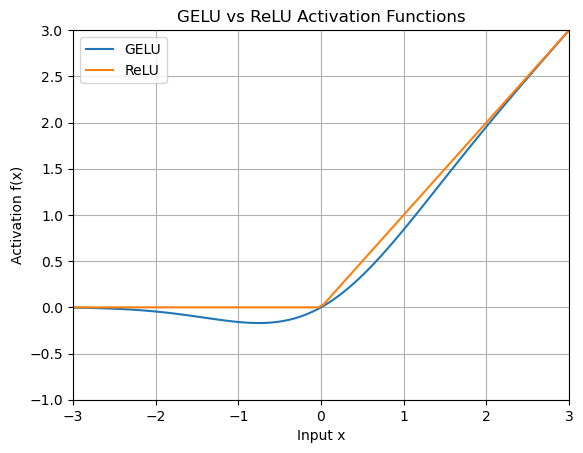

In [26]:
x = torch.linspace(-3, 3, 100)
gelu = GELU()
gelu_output = gelu(x)
relu = torch.nn.ReLU()
relu_output = relu(x)

plt.plot(x, gelu_output, label="GELU")
plt.plot(x, relu_output, label="ReLU")
plt.xlim([-3, 3])
plt.ylim([-1, 3])
plt.xlabel("Input x")
plt.ylabel("Activation f(x)")
plt.title("GELU vs ReLU Activation Functions")
plt.legend()
plt.grid(True)
plt.show()

## FeedForward

The **feedforward network (FFN)**, also called the *position-wise MLP*, is applied independently to each token embedding after the attention layer.  

The intermediate MLP is typically designed as a **2-layer MLP**, where the hidden dimension is an integer multiple of the input dimension  (e.g., 3x, 4x; here we use 4x).  
A nonlinearity is applied in between (commonly GELU in modern LLMs) and **no biases** are used in the linear layers (as per standard transformer implementations). 

In [27]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

## Transformer Block

A commonly used variant, used here, is the **pre-normalized transformer block**, which tends to be easier to train.  
Its structure is as follows:

1. Start with a layer normalization operation: $\mathbf{H}=\operatorname{LayerNorm}(\mathbf{X})$
2. Apply a MHA layer: $\mathbf{H}=\mathrm{MHA}(\mathbf{H})$.
3. Add a residual connection: $\mathbf{H}=\mathbf{H}+\mathbf{X}$.
4. Apply a layer normalization operation: $\mathbf{F}=\operatorname{LayerNorm}(\mathbf{F})$
5. Apply a fully-connected model $g(\cdot)$ on each row $\mathbf{F}=g(\mathbf{F})$.
6. Add a residual connection: $\mathbf{F}=\mathbf{F}+\mathbf{H}$.

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # x.shape = [batch_size, num_tokens, emb_size]
        shortcut = x
        x = self.norm1(x)
        # x.shape = [batch_size, num_tokens, emb_size]
        x = self.att(x) 
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        # [batch_size, num_tokens, emb_size] -> [batch_size, num_tokens, emb_size]
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x # x.shape = [batch_size, num_tokens, emb_size]

## GPT Model

Let  
$$
\mathbf{X} \in \mathbb{R}^{b \times n \times vocab}
$$  
be the input token indices, where:
- $b$ = batch size,  
- $n$ = context length (number of tokens)
- $vocab$ = vocabulary size

Since each element of $\mathbf{X}$ is an integer index in the vocabulary, the first step is to map tokens into continuous vectors using **token embeddings**:  

$$
\mathbf{T} \in \mathbb{R}^{b \times n \times d},
$$  

where $d$ is the embedding dimension.  

We then add **positional embeddings**  
$$
\mathbf{P} \in \mathbb{R}^{n \times d}
$$  
to encode the order of tokens in the sequence:

$$
\mathbf{E} = \mathbf{T} + \mathbf{P}, \qquad 
\mathbf{E} \in \mathbb{R}^{b \times n \times d}.
$$

A dropout layer is applied for regularization:

$$
\mathbf{E}' = \operatorname{Dropout}(\mathbf{E}).
$$


The embedded sequence $\mathbf{E}'$ is then passed through a stack of $L$ **transformer blocks**:

$$
\mathbf{H} = \operatorname{TransformerBlocks}(\mathbf{E}'),
\qquad \mathbf{H} \in \mathbb{R}^{b \times n \times d}.
$$

Finally, we apply **layer normalization** followed by a **linear output head** that projects embeddings into vocabulary logits:

$$
\mathbf{Z} = \operatorname{LN}(\mathbf{H}), \qquad
\mathbf{Y} = \mathbf{Z} W,
$$

where $W \in \mathbb{R}^{d \times vocab}$.  

Thus, the model produces logits:

$$
\mathbf{Y} \in \mathbb{R}^{b \times n \times vocab},
$$

which can be converted into probabilities over the vocabulary using softmax for next-token prediction.


In [ ]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        # x.shape = [b, context_length, vocab_size]
        batch_size, seq_len = in_idx.shape
        # Token embedding: [b, context_length, vocab_size] => [b, context_length, emd_dim] 
        tok_embeds = self.tok_emb(in_idx)
         # Pos embedding: [b, context_length, emd_dim] 
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        # # Shape [batch_size, context_length, emb_size] => [batch_size, context_length, emb_size]
        x = tok_embeds + pos_embeds  
        # # Shape [batch_size, context_length, emb_size] => [batch_size, context_length, emb_size]
        x = self.drop_emb(x) 
        # # Shape [batch_size, context_length, emb_size] => [batch_size, context_length, emb_size]
        x = self.trf_blocks(x)
        # # Shape [batch_size, context_length, emb_size] => [batch_size, context_length, emb_size]
        x = self.final_norm(x) 
        # Shape [batch_size, context_length, emb_size] => [batch_size, context_length, vocab_size]
        logits = self.out_head(x)  #  [batch_size, context_length, vocab_size]
        return logits # [batch_size, context_length, vocab_size]


# Training 

In [32]:
def train_model(model, train_loader, val_loader, optimizer, device,
                n_epochs, eval_freq, eval_iter, start_context, tokenizer,
                warmup_steps, initial_lr=3e-05, min_lr=1e-6):
    
    train_losses, val_losses, track_tokens_seen, track_lrs = [], [], [], []
    token_seen, global_step = 0, -1

    peak_lr = optimizer.param_groups[0]["lr"]
    total_training_steps = len(train_loader) * n_epochs
    lr_increment = (peak_lr - initial_lr) / warmup_steps

    for epoch in range(n_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            global_step +=1

            if global_step < warmup_steps:
                lr = initial_lr + global_step * lr_increment
            else:
                progress = ((global_step - warmup_steps) /
                            (total_training_steps - warmup_steps))
                lr = min_lr + (peak_lr - min_lr) * 0.5 * (
                    1 + math.cos(math.pi * progress))
            
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr
            track_lrs.append(lr)

            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()

            if global_step > warmup_steps:
                torch.nn.utils.clip_grad_norm_(
                    model.parameters(), max_norm=1.0
                )
            
            optimizer.step()
            token_seen += input_batch.numel()

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model,  train_loader, val_loader,
                    device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(token_seen)
                print(f"Ep {epoch+1} (Iter {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                      )
                
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen, track_lrs

In [33]:
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1)


torch.manual_seed(SEED)
train_losses, val_losses, tokens_seen, lrs = train_model(
    model, train_loader, val_loader, optimizer, device, n_epochs=N_EPOCHS,
    eval_freq=5, eval_iter=1, start_context=START_CONTEXT,
    tokenizer=tokenizer, warmup_steps=WARMUP_STEPS,
    initial_lr=INITIAL_LR, min_lr=MIN_LR
)

Ep 1 (Iter 000000): Train loss 10.942, Val loss 10.947
Ep 1 (Iter 000005): Train loss 9.010, Val loss 9.248
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Iter 000010): Train loss 7.500, Val loss 7.801
Ep 2 (Iter 000015): Train loss 5.996, Val loss 6.696
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 3 (Iter 000020): Train loss 5.774, Val loss 6.684
Ep 3 (Iter 000025): Train loss 5.774, Val loss 6.713
Every effort moves you of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the
Ep 4 (Iter 000030): Train loss 5.412, Val loss 6.522
Ep 4 (Iter 000035): Train loss 3.970, Val loss 6.633
Every effort moves you know the to the the picture to the picture to the picture my the picture in the picture--and, I had the to the picture to the the picture to the picture to the picture to the picture to the picture my the pi

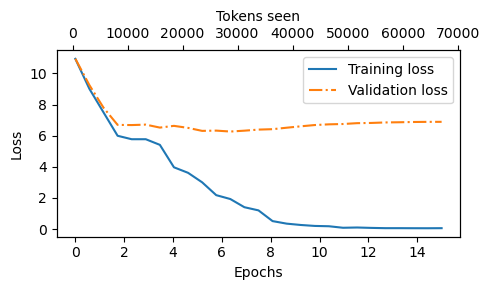

In [34]:
epochs_tensor = torch.linspace(0, N_EPOCHS, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)


# Generate new text

In [ ]:
def generate(model, idx, max_new_tokens, context_size,
             temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        # Keep only the last `context_size` tokens as input for the model
        idx_cond = idx[:, -context_size:]

        with torch.no_grad(): # Inference mode
            logits = model(idx_cond) # Model outputs raw logits for all positions

        # [b, sequence_lenght, vocab_size] -> [b, 1, vocab_size] 
        logits = logits[:, -1, :] # Consider only the logits for the last position in sequence_lenght

        # Apply top-k sampling if specified
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k) # Get top-k logits
            min_val = top_logits[:, -1]  # smallest value in top-k
            # Set the logits outside top-k to -inf so they won't be sampled
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )


        if temperature > 0.0:
            logits = logits / temperature # Scaling the logits by temperature
            probs = torch.softmax(logits, dim=-1) # Convert logits to probabilities
            idx_next = torch.multinomial(probs, num_samples=1) #sample next token
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True) # greedy-selection

        # Stop generation if end-of-sequence token is generated
        if idx_next == eos_id:
            break
        
        # Append the prediction token to the sequence (autoregressive model)
        idx = torch.cat((idx, idx_next), dim=1)

    return idx # return the full sequence including generated tokens 

In [36]:
model.to("cpu")
model.eval()
print("Model set in evaluation mode.")

Model set in evaluation mode.


In [37]:
torch.manual_seed(SEED)

token_ids = generate(
    model=model,
    idx=text_to_token_ids(START_CONTEXT, tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know began to happen a little wild--I felt nervous and uncertain.



# Saving the model

In [38]:
# torch.save({
#     "model_state_dict": model.state_dict(),
#     "optimizer_state_dict": optimizer.state_dict(),
# },
# "model_and_optimizer.pth"
# )